# Single Cell Sequencing: Control Atras and transferlabels


In [1]:
!pip install --quiet anndata
import os
import config as general_paths
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
#doublet detection
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
sb.set_context(context='poster')
from matplotlib import rcParams
from datetime import date
today = date.today()
import seaborn as sns

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.24.3 scipy==1.11.1 pandas==1.5.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.11.6 louvain==0.8.2 pynndescent==0.5.12


In [2]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
input_path = output_path
local_path = general_paths.local_path

In [3]:
adata = ad.read_h5ad(os.path.join(input_path , 'campari_scs_from_R.h5ad'))
adata_all = ad.read_h5ad(os.path.join(input_path , 'campari_scs_all_genes_from_R.h5ad'))


# List of genes to exclude
genes_to_exclude =  ['TdTomato','Cre','Campari','EGFP','mNeptune','ReachR','flp0','iCre','Calm1'] 
# Filter the adata object to keep only the genes not in the exclusion list
adata = adata[:, ~adata.var_names.isin(genes_to_exclude)].copy()

print(adata.shape)

(3658, 15993)


In [4]:
x = adata.X
stim = np.zeros((x.shape[0],))
for i in range(x.shape[0]):
    stim[i] = adata.obs['stimulus'][i]
## We split the cels between campari and control cells
campari_cells = np.where(stim != 0)[0]
control_cells = np.where(stim == 0)[0]
print('Number of campari cells = ', len(campari_cells))
print('Number of control cells = ', len(control_cells))
adata_campari = adata[campari_cells,:]
adata_control = adata[control_cells,:]

adata_all_control = adata_all[control_cells,:]
adata_all_campari = adata_all[campari_cells,:]

Number of campari cells =  2631
Number of control cells =  1027


In [5]:
### Dimentionality reduction examples using multiple techniques
### Select one number of componets, for example n = 15 and do louvain in the umap transformation 
# with that number of componets
N_selected = 24
sc.pp.pca(adata_control, n_comps=N_selected, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_control)
sc.tl.tsne(adata_control)
sc.tl.umap(adata_control)

computing PCA
    with n_comps=24
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 24


/home/melma31/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing tSNE
    using 'X_pca' with n_pcs = 24
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


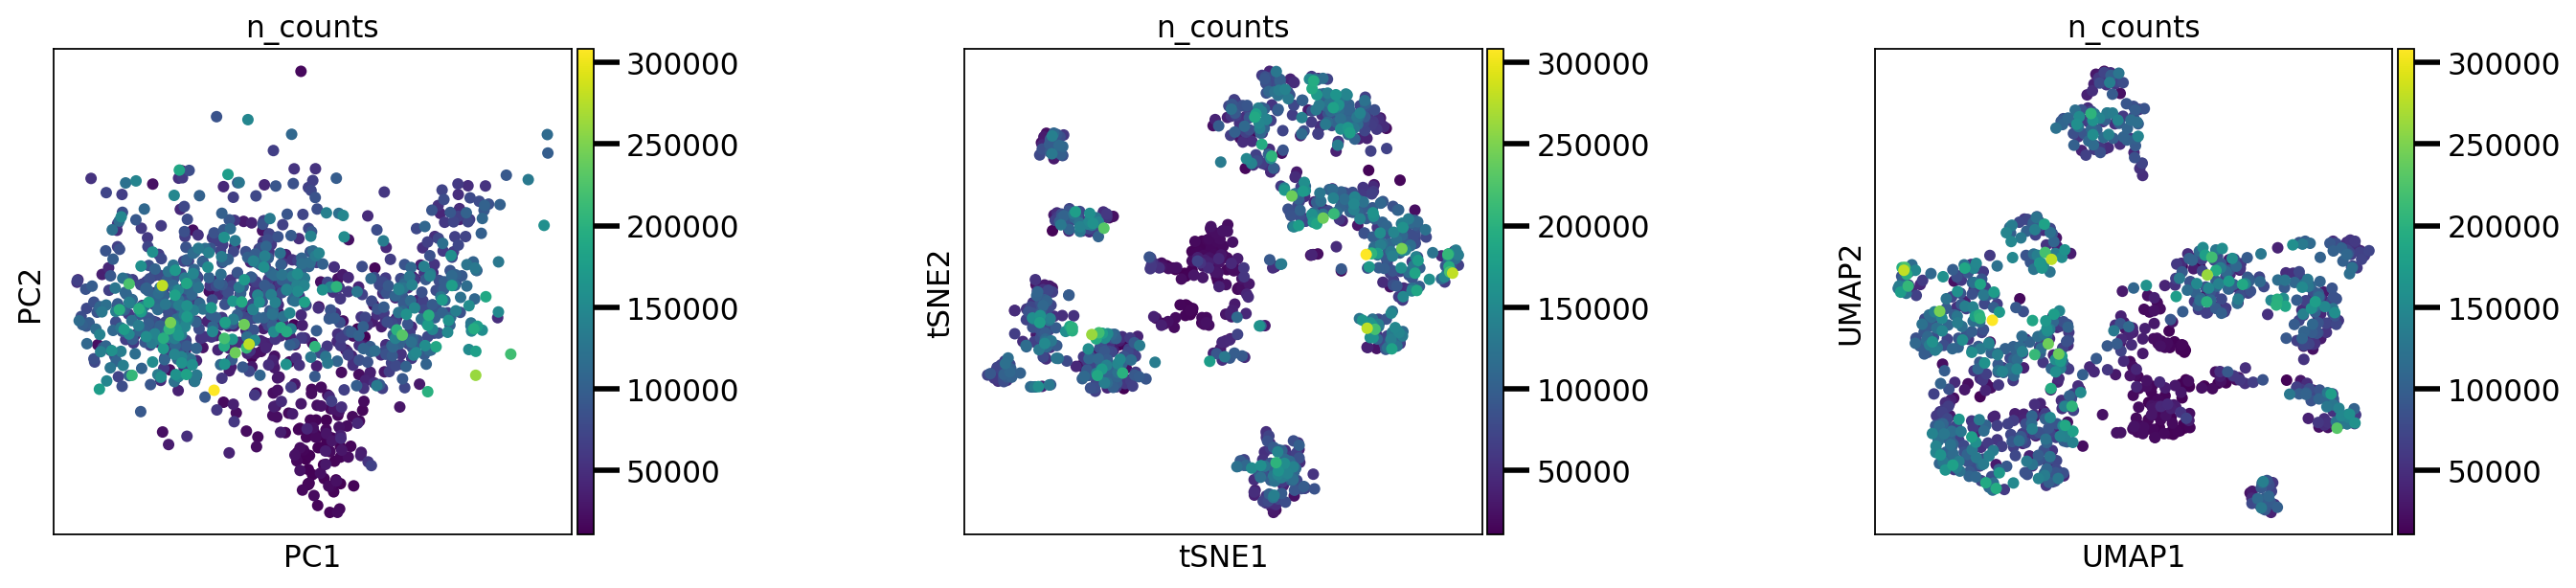

In [6]:
from matplotlib import rcParams

rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata_control, color='n_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata_control, color='n_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata_control, color='n_counts', ax=fig.add_subplot(fig_ind[2]), show=False)

In [7]:
# Perform clustering - using highly variable genes ### maybe change to Leiden
louvain_paramenters = [0.3,0.5,1,1.5,2,2.5,3,3.5,4,4.5,6]
louvain_names = []
for value in louvain_paramenters:
    louvain_names.append('louvain_r' + str(value))

for value,name in zip(louvain_paramenters,louvain_names):
    sc.tl.louvain(adata_control, resolution=value, key_added=name)  

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain_r0.3', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain_r2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" 

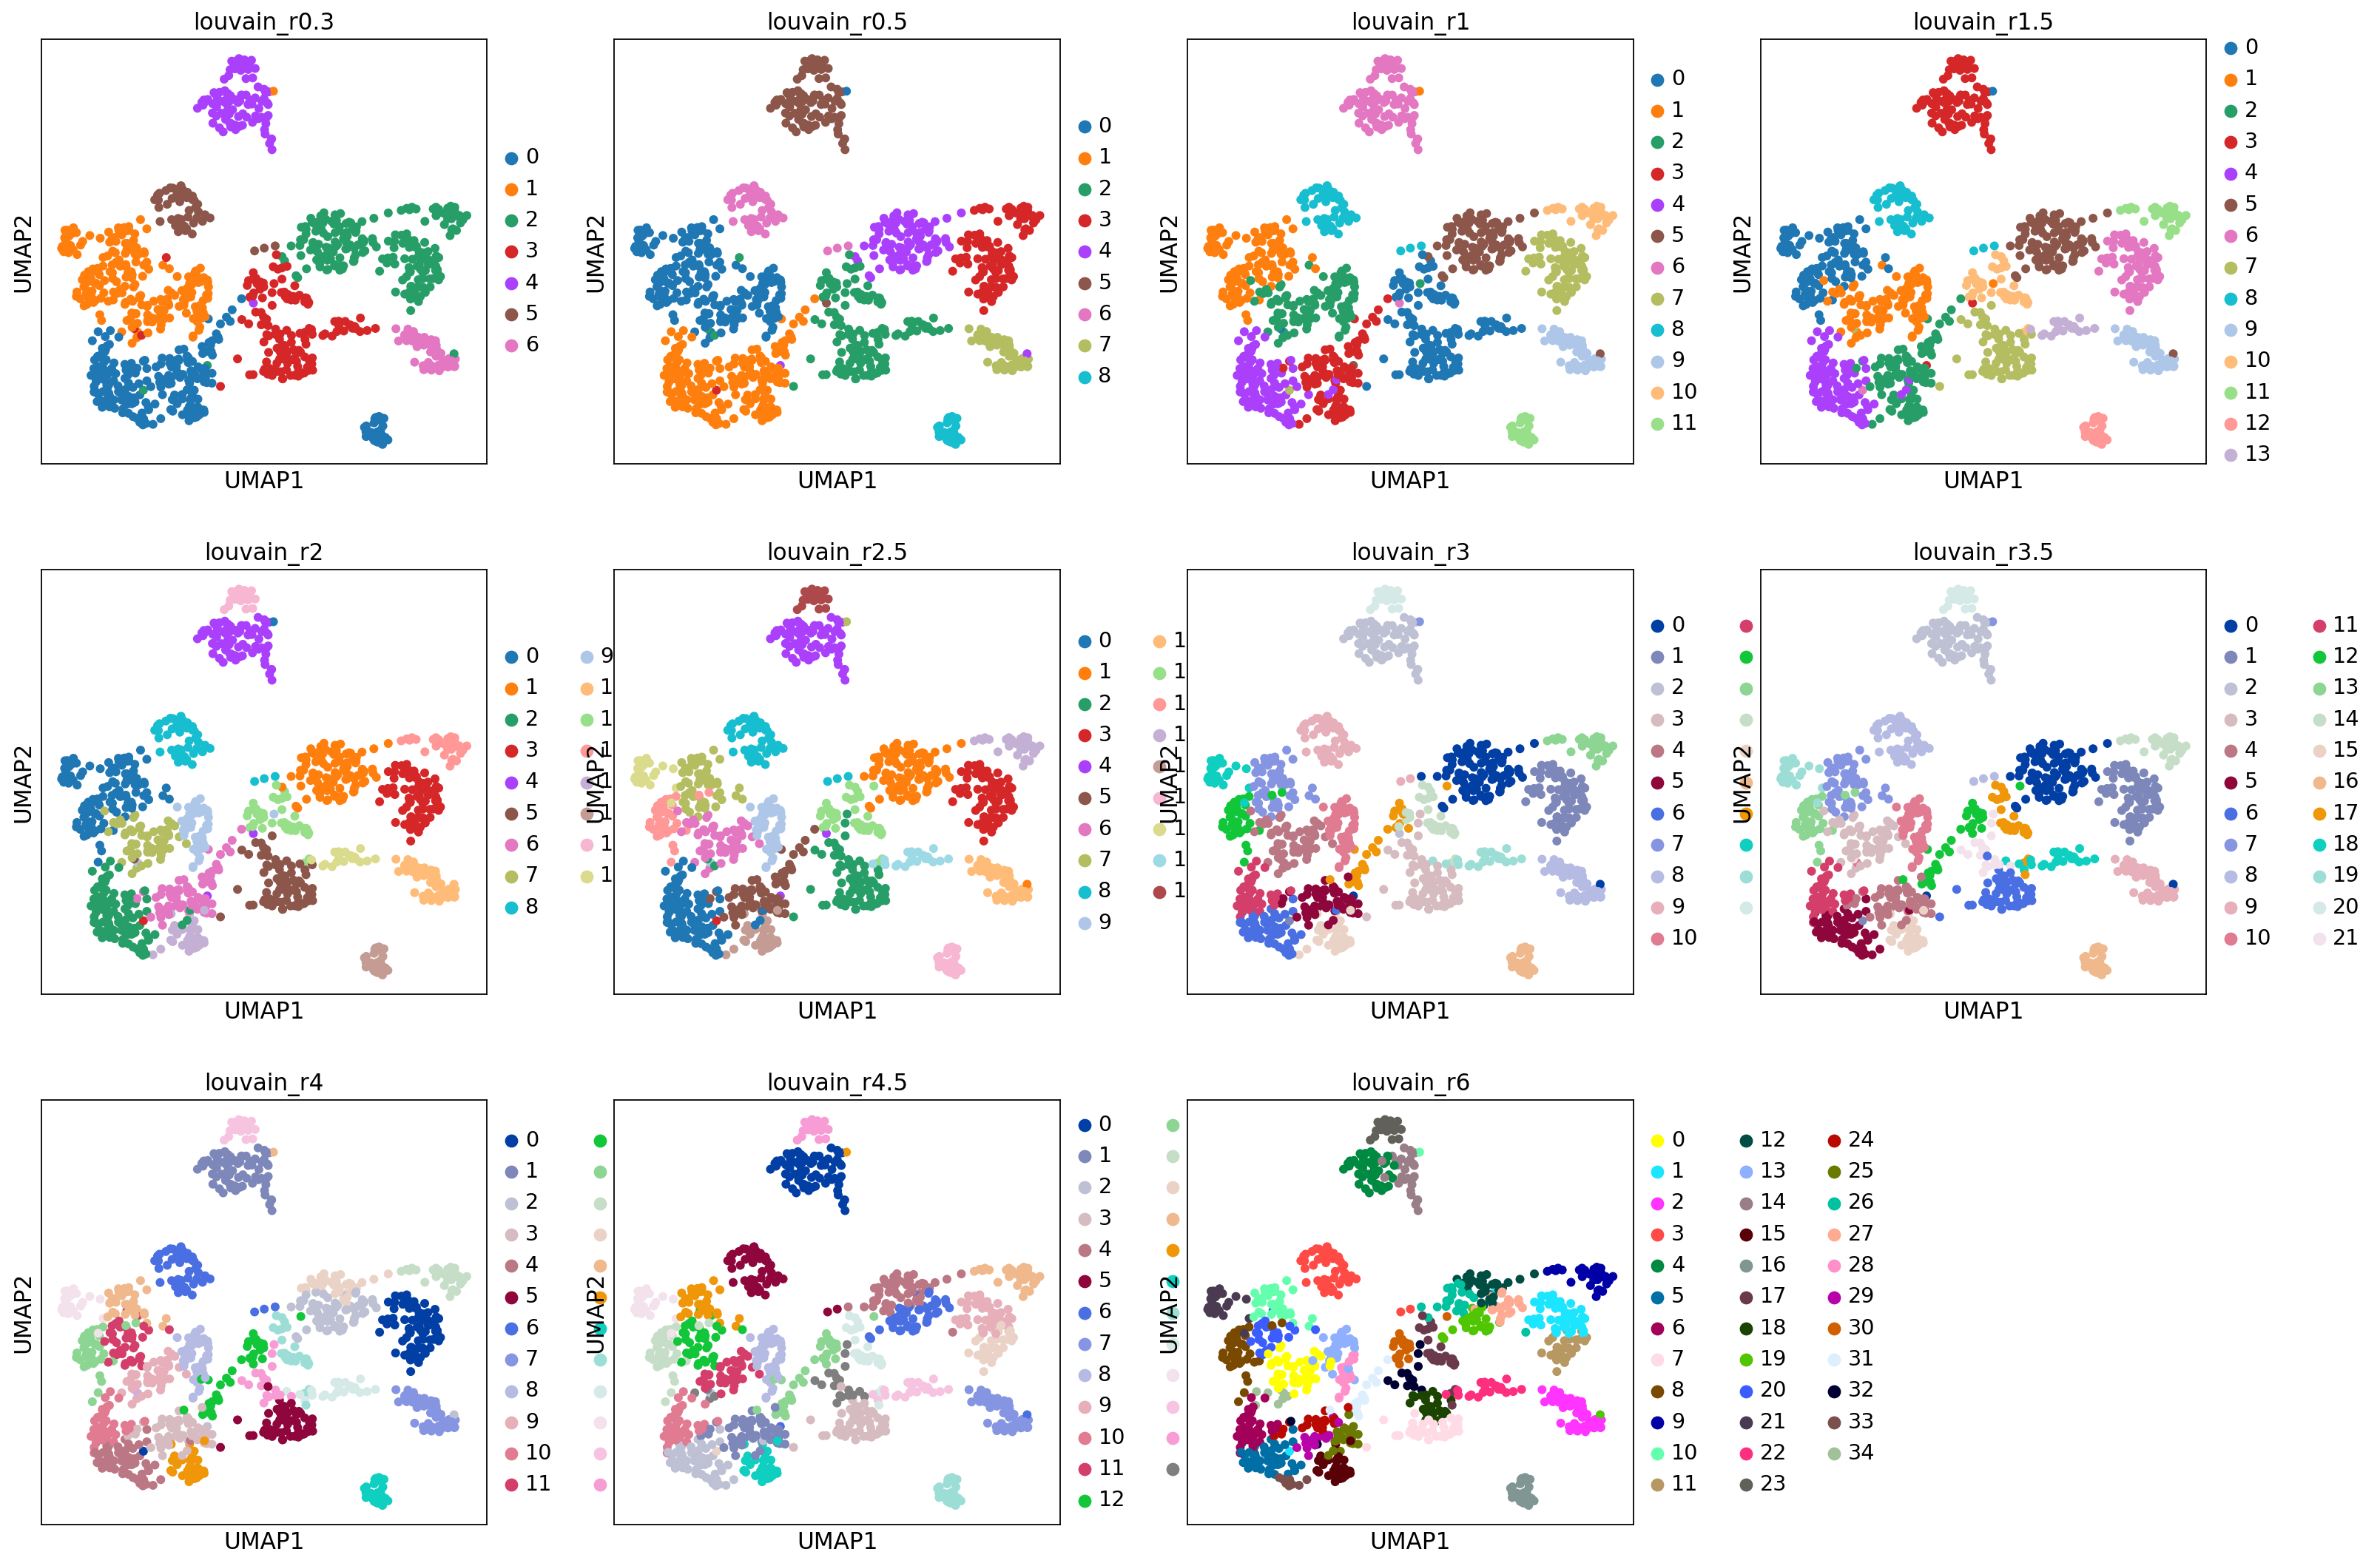

In [8]:
rcParams['figure.figsize']=(5,5)
#Visualize the clustering and how this is reflected by different technical covariates
#for name in louvain_names:
sc.pl.umap(adata_control, color=louvain_names, save = 'UMIs/louvain/'+name + 'control_atlas_from_R.png')
#sc.pl.umap(adata, color=['log_counts','stimuli'])

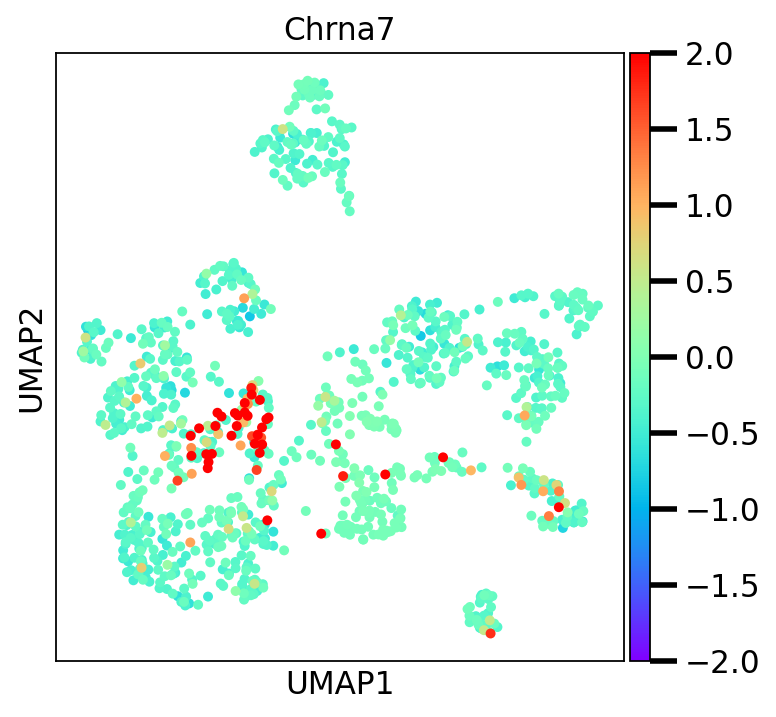

In [54]:
marker_genes = ['Krt79','Trpm3','Piezo2','Trpm2','Smr2','Sstr2','Bmpr1b','Trpm8','Trpv1','Piezo2','Piezo1','Nppb',
                'Sst','Pvalb','Prokr2','Mrgprd','Mrgpra3','Cd34',
                'Th','Trpa1','Ntrk3','Ntrk2','Ntrk1','Ret','Tac1','Calca','Calcb','Nefh',
                'S100b','Scn10a','Slc17a8','Atf3','Pou4f3','Calb1','Calb2','Avil','Asic3',
                'Asic2','Asic1','Pou6f2','Avpr1a','Pou4f2','Sox10','Casq2','Chrna7','Chrna3',
                'P2rx3','Ldhb','Necab2','Spp1','Adm','Hpse','Adra2a','Rbfox3']
marker_genes = ['Chrna7']
sc.pl.umap(adata=adata_control, color=marker_genes, use_raw=False, cmap = 'rainbow',save = 'UMIs/expression/genes_control_cells_marker_genes' + '.png',
           size = 80,vmin=-2, vmax=2)

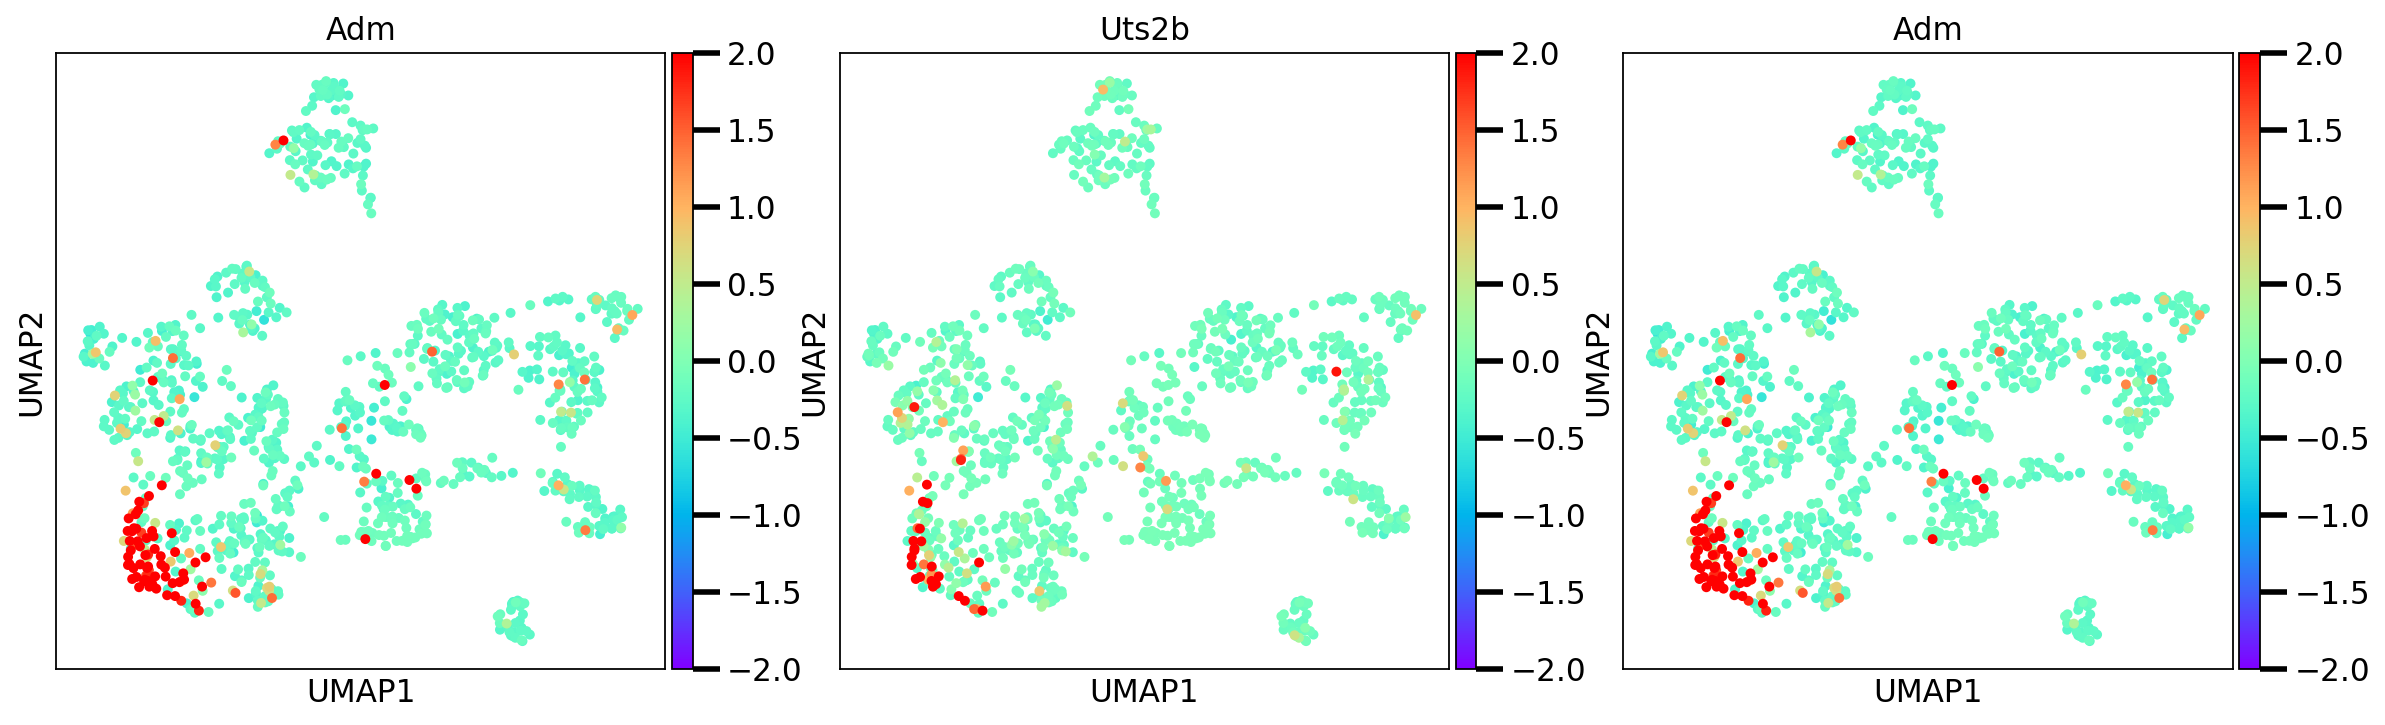

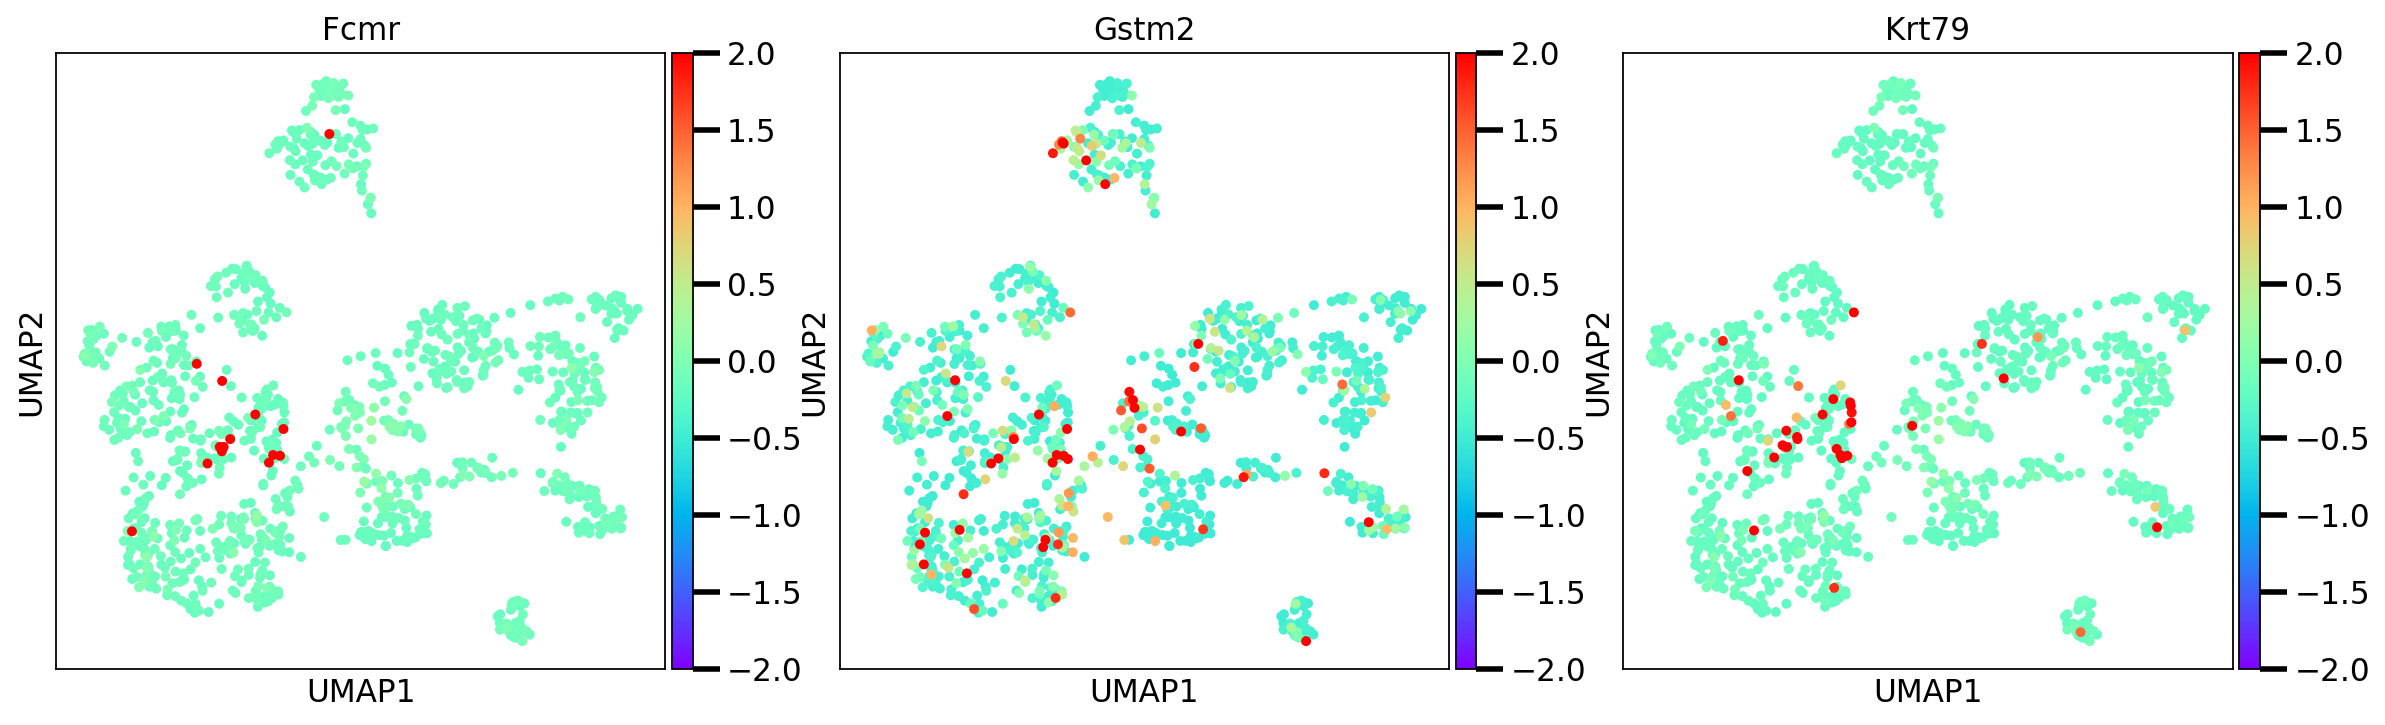

In [55]:
rcParams['figure.figsize']=(5,5)

marker_genes = ['Adm','Uts2b','Adm']
sc.pl.umap(adata=adata_control, color=marker_genes, use_raw=False, cmap = 'rainbow',save = 'UMIs/expression/genes_control_cells_marker_Adm_' + '.png',
           size = 80,vmin=-2, vmax=2)
marker_genes = ['Fcmr','Gstm2','Krt79']
sc.pl.umap(adata=adata_control, color=marker_genes, use_raw=False, cmap = 'rainbow',save = 'UMIs/expression/genes_control_cells_marker_Adm_' + '.png',
           size = 80,vmin=-2, vmax=2)

Text(0, 0.5, 'UMAP2')

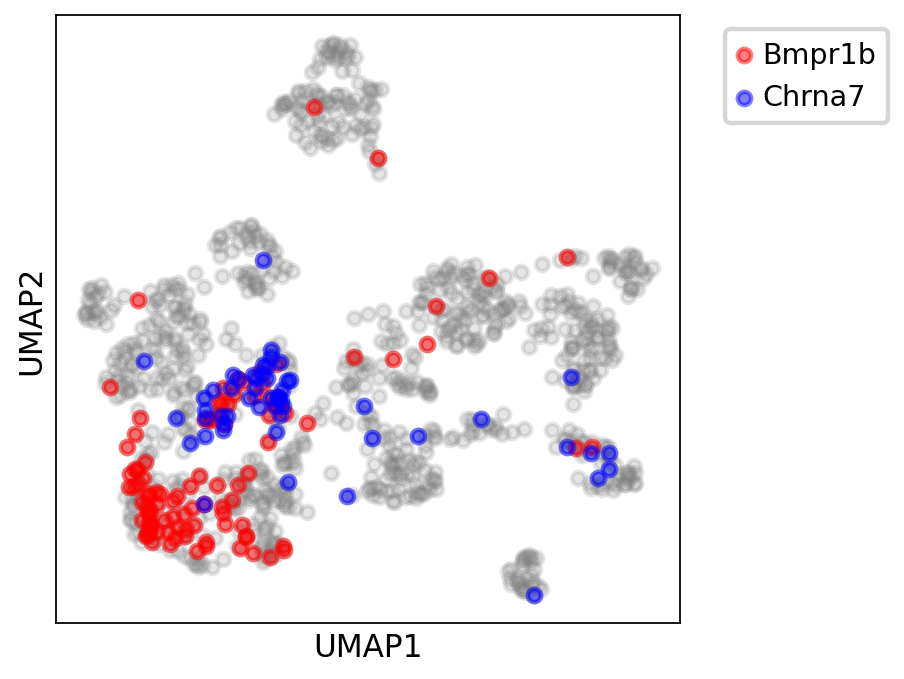

In [56]:
# show selected genes on same umap (each gene, different color)
genes2show = ['Bmpr1b','Chrna7']
# select colors for those genes
my_colors = ['r','b']
# select thresholds values for those genes (above which value to show them)
threshold = 1# show selected genes on same umap (each gene, different color)

figure, axes = plt.subplots()
# show umap as gray alpha dots
axes.scatter(adata_control.obsm['X_umap'][:,0],adata_control.obsm['X_umap'][:,1],c='gray',alpha=0.2)
for i in range(len(genes2show)):
    # normalized values for each gene at each point of umap representation
    my_gene_values = adata_control.obs_vector(genes2show[i])
    # select which to show (use threshold)
    my_gene_indexes_above_threshold = np.where(my_gene_values > threshold)[0]
    axes.scatter(adata_control.obsm['X_umap'][my_gene_indexes_above_threshold,0],adata_control.obsm['X_umap'][my_gene_indexes_above_threshold,1],c=my_colors[i],alpha=0.5,label=genes2show[i])
axes.grid(False)
axes.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
figure.set_size_inches([5,5])    
# Hide X and Y axes tick marks
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('UMAP1')
axes.set_ylabel('UMAP2')
#fig_title = fig_title+"above_"+str(threshold)
#figure.savefig(os.path.join(figure_path, fig_title+'.png'))

## We choose a clustering method

Here we choose a Louvain order, and we run ingestion with campari cells and we quantify the stimuli.

In [57]:
clustering_method = 'louvain_r2'

cluster_names =  {
    0: 'cluster0',
    1: 'cluster1',
    2: 'cluster2',
    3: 'cluster3',
    4: 'cluster4',
    5: 'cluster5',
    6: 'cluster6',
    7: 'cluster7',
    8: 'cluster8',
    9: 'cluster9',
    10: 'cluster10',
    11: 'cluster11',
    12: 'cluster12'
}

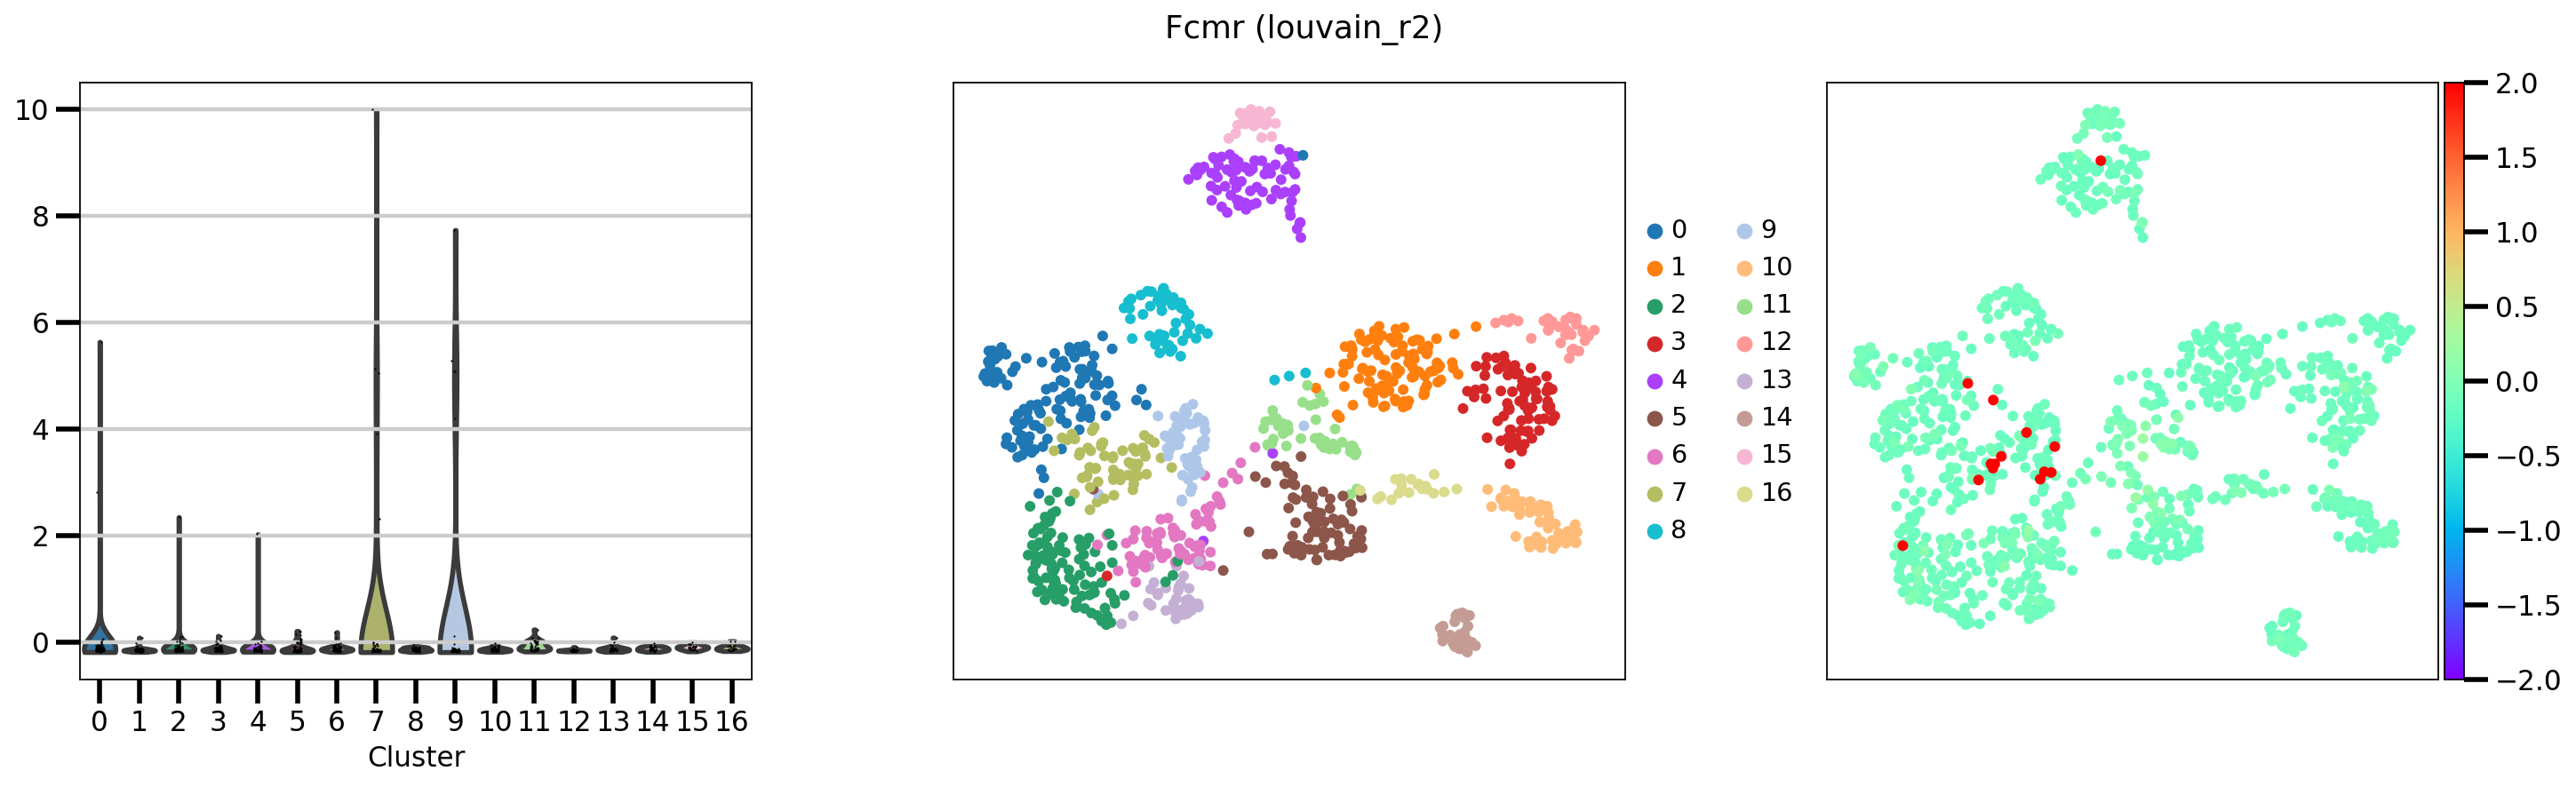

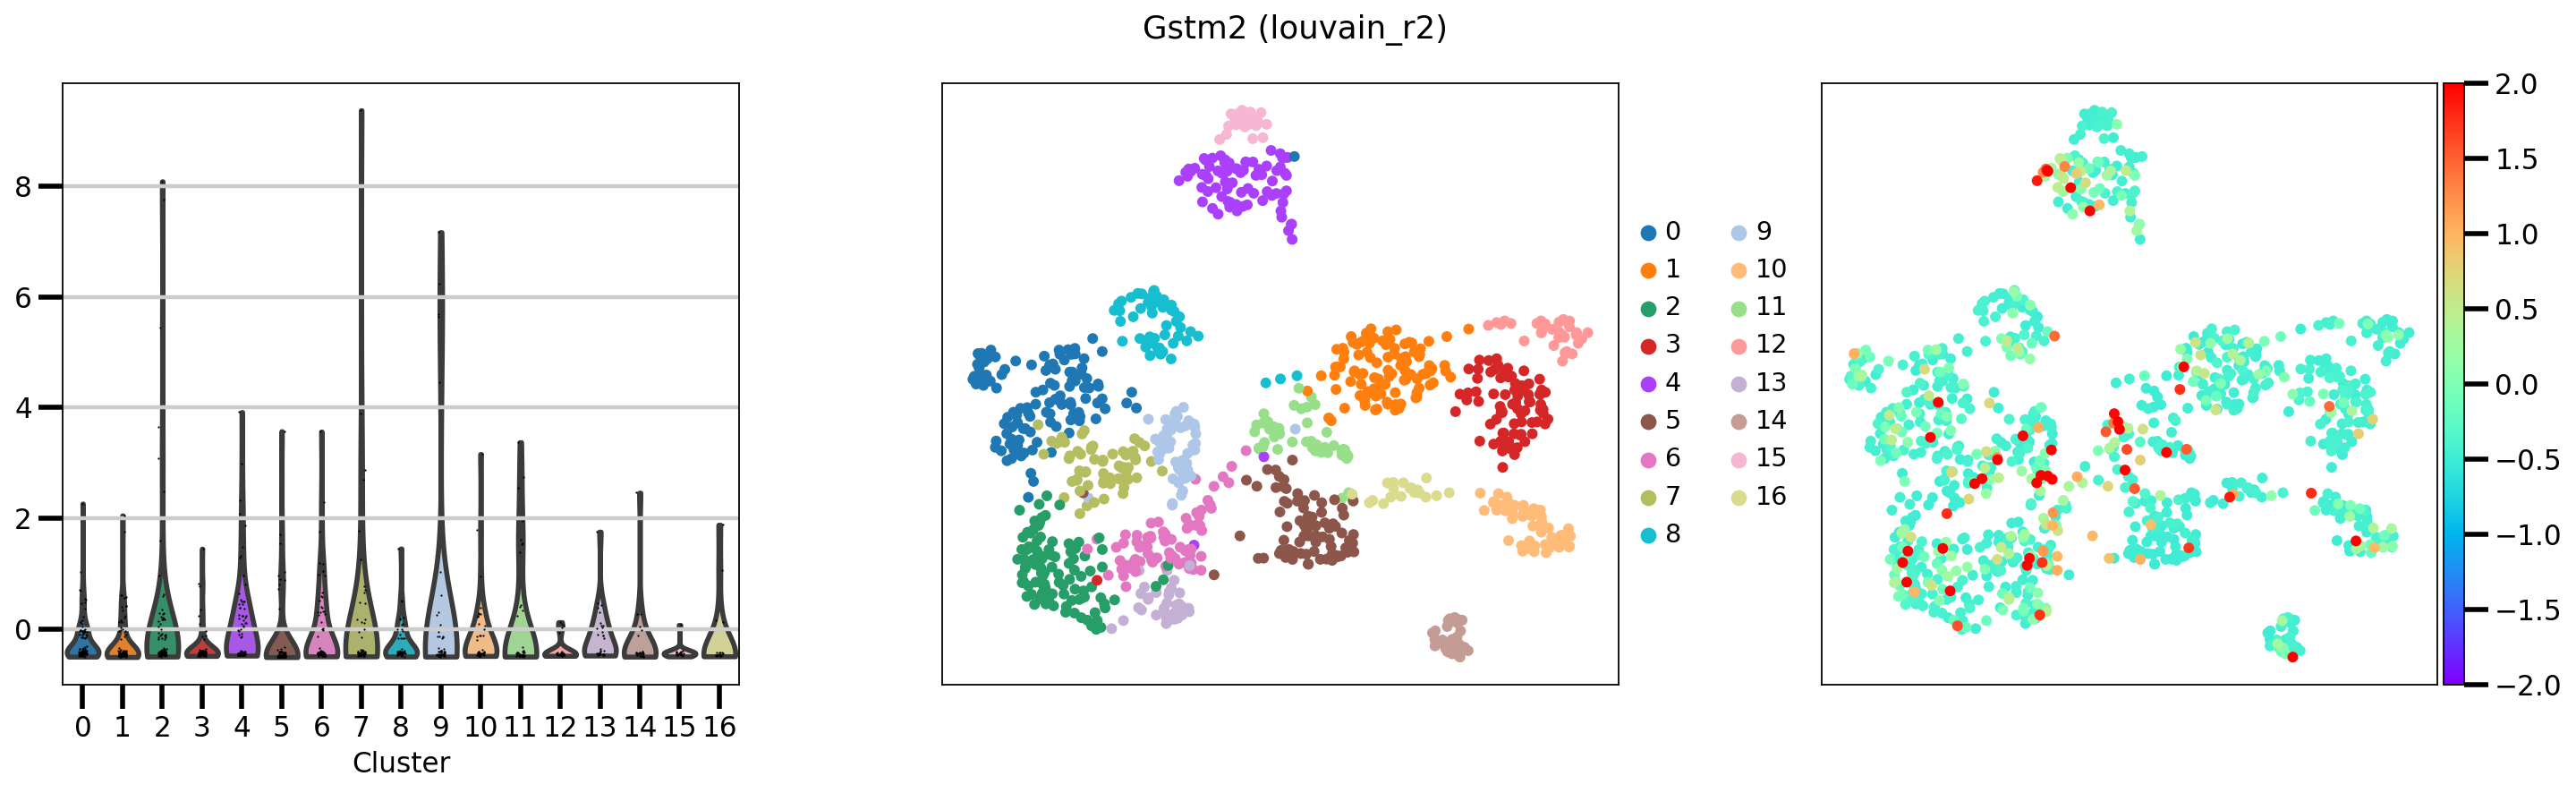

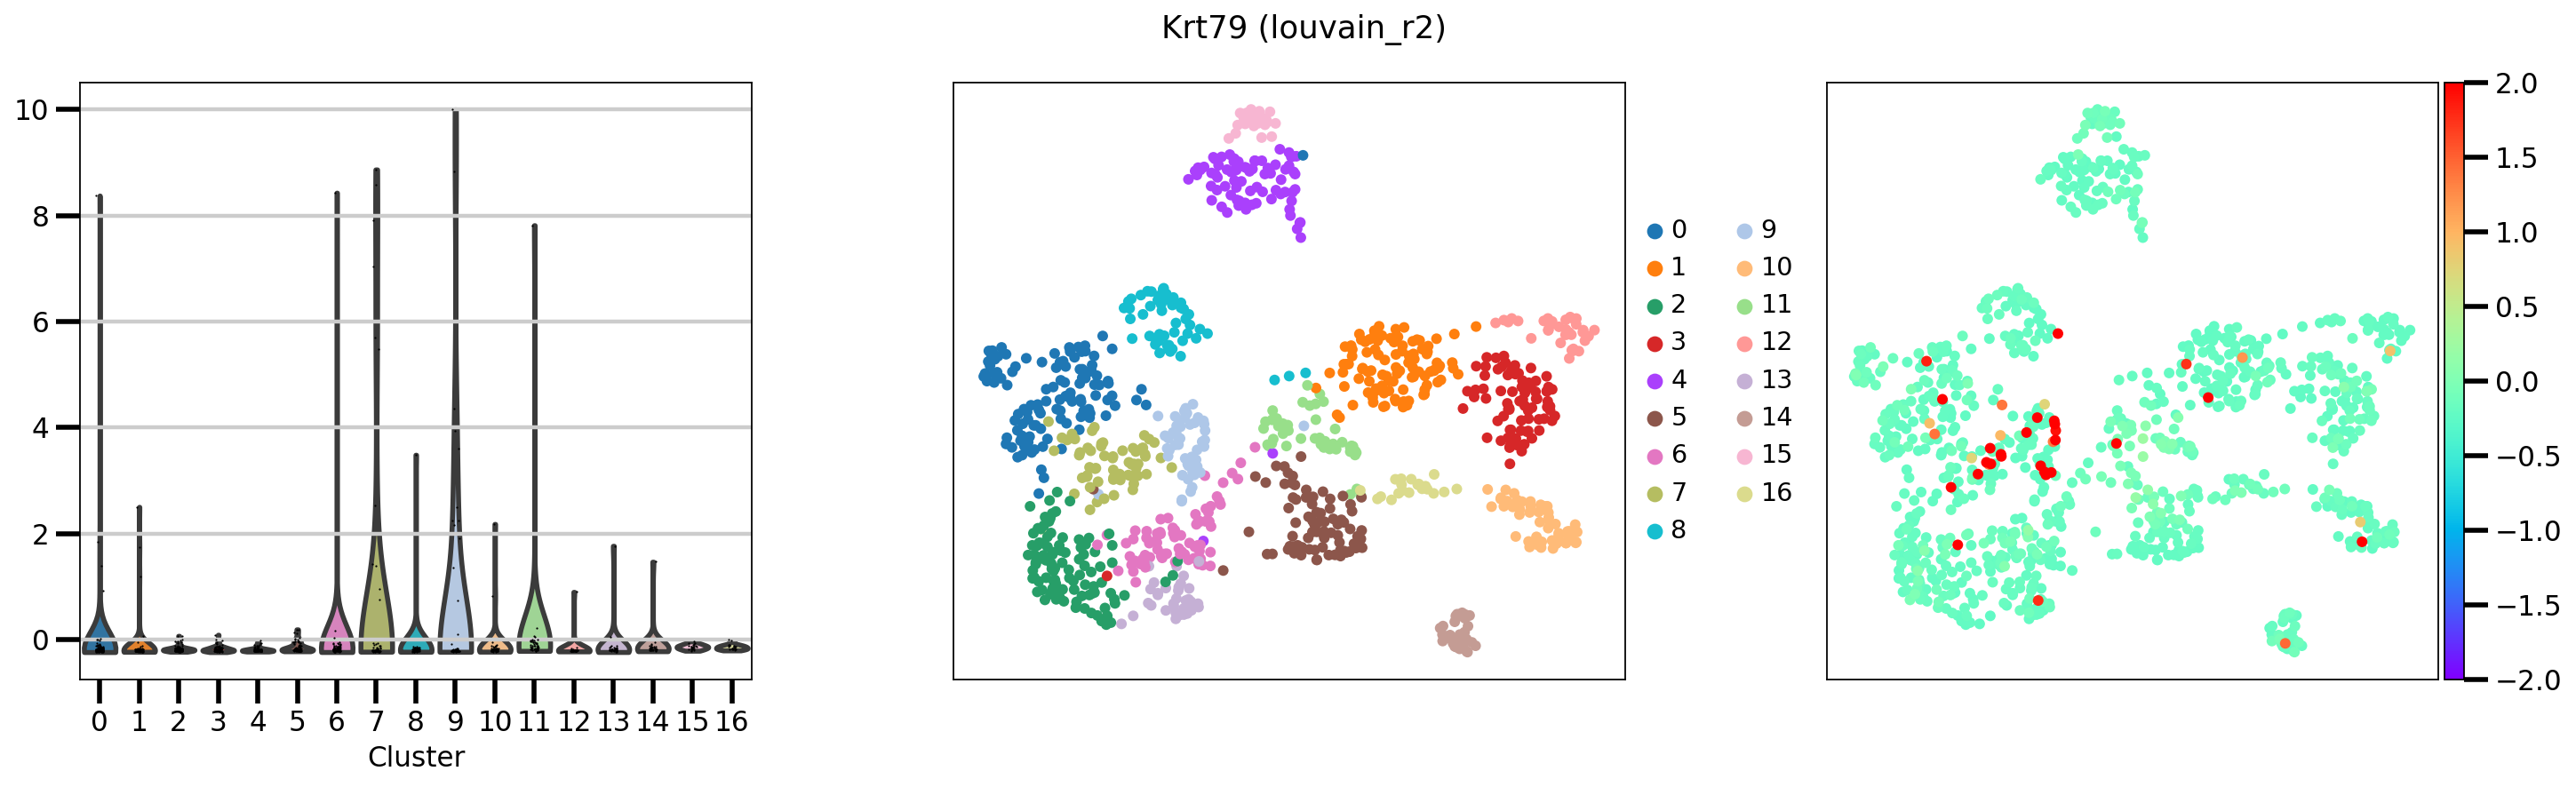

In [58]:
# for each gene, show 3 plots next to each other:
# 1) gene value distribution in each cluster (violin plot)
# 2) umap plot with clusters (to see where each cluster number is)
# 3) umap plot with gene value distribution in each cluster (values to colormap)
MY_LEFT = 0.09
MY_RIGHT = 0.9
MY_TOP = 0.9
MY_BOTTOM = 0.2
MY_WSPACE = 0.3
MY_HSPACE = 0.5
# Show violin plots next to clasters
# compare a certain gene across clasters
for gene in marker_genes:
    # This produces two Axes objects in a single Figure
    ncols=3
    nrows=1
    figsize=5
    wspace=0.2
    fig,ax = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(ncols*figsize+figsize*wspace*(ncols-1)+4,nrows*figsize+1))
    plt.subplots_adjust(left=MY_LEFT, 
                    bottom=MY_BOTTOM,  
                    right=MY_RIGHT,  
                    top=MY_TOP,  
                    wspace=MY_WSPACE,  
                    hspace=MY_HSPACE)
    fig.suptitle(gene+' ('+clustering_method+')\n', fontsize=16)
    # We can use these Axes objects individually to plot on them
    # We need to set show=False so that the Figure is not displayed before we
    # finished plotting on all Axes and making all plot adjustments
    sc.pl.violin(adata_control, gene, use_raw=False, groupby=clustering_method,xlabel='Claster', ylabel='',ax=ax[0],show=False)
    ax[0].set_xlabel("Cluster") # change x label from louvain to claster
    ax[0].set_ylabel("")
    sc.pl.umap(adata_control, color=clustering_method, use_raw=False, title='', ax=ax[1],show=False)
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")
    sc.pl.umap(adata_control, color=gene, use_raw=False, cmap = 'rainbow',title='', ax=ax[2],show=False,vmin=-2, vmax=2)
    ax[2].set_xlabel("")
    ax[2].set_ylabel("")
    ax[2].set_xticks([])
    ax[2].set_yticks([]) 
    plt.show()
    fig.savefig(os.path.join(figure_path , 'violin_'+gene+'_'+clustering_method+'.png'))

In [12]:
sc.tl.ingest(adata_campari, adata_control, obs=clustering_method, embedding_method='umap')

running ingest


/home/melma31/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:24)


<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['rep']` of view, initializing view as actual.
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.


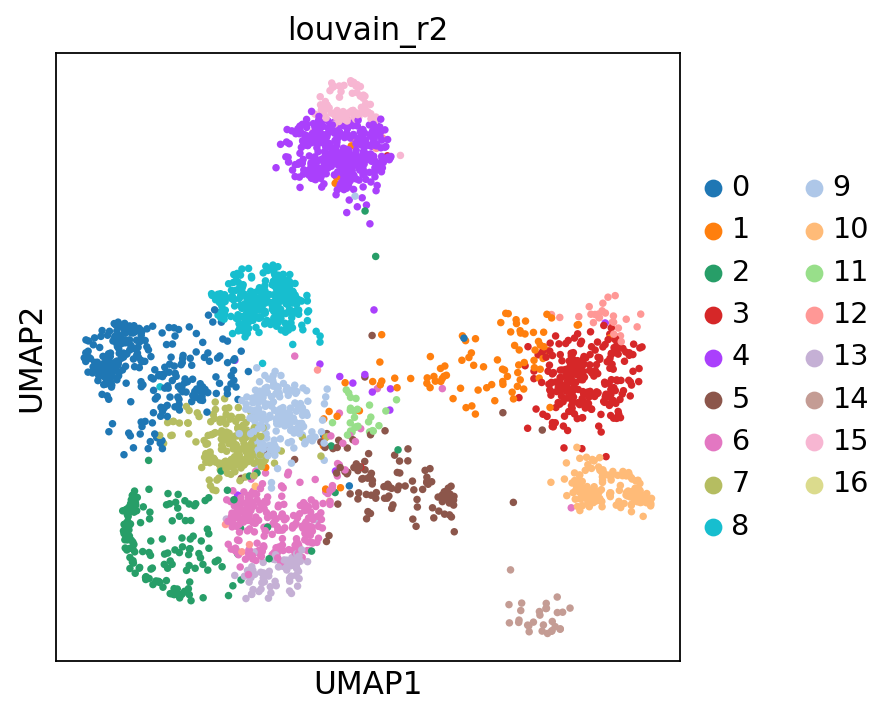

In [13]:
sc.pl.umap(adata_campari, color=[clustering_method], wspace=0.3)
adata_campari.obs['transfered_clusters'] = adata_campari.obs[clustering_method]
adata_control.obs['clusters'] = adata_control.obs[clustering_method]

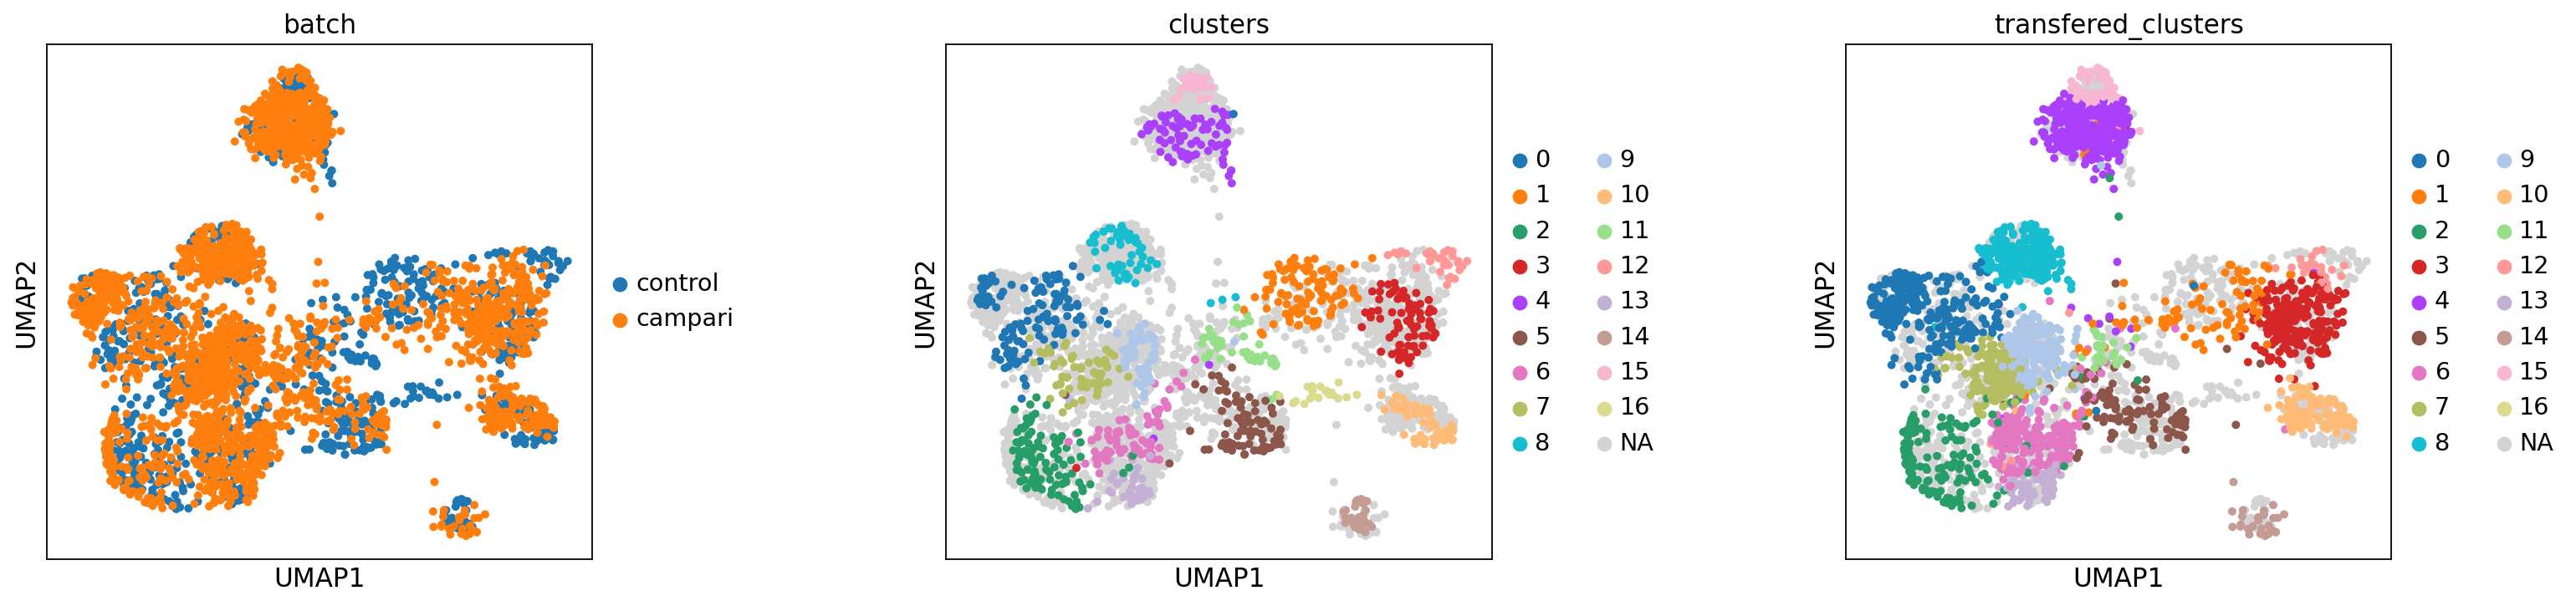

In [14]:
adata_concat = adata_control.concatenate(adata_campari, batch_categories=["control", "campari"])
adata_all_concat = adata_all_control.concatenate(adata_all_campari, batch_categories=["control", "campari"])

# fix category ordering
#adata_concat.obs.louvain.cat.reorder_categories(
#    adata_human.obs.louvain.cat.categories, inplace=True
#)
# fix category colors
sc.pl.umap(adata_concat, color=["batch", 'clusters',"transfered_clusters"], wspace = 0.5,save = 'UMIs/integration_control_campari.png', size = 80,
              vmin=-2, vmax=2)

In [25]:
Stimuli_names = {
    0: "Control",
    1: 'pinch',
    2: 'new_stroke',
    3: 'ballon',
    4: 'AGB',
    5: 'AD',
    6: 'heating',
    7: 'mock',
    8: 'old_stoke',
    9: 'anal pinch',
    10: 'Mock_w_poop',
    11: 'VG',
    12: 'Tomato',
    13: 'poop',
    14: 'Bladder',
    15: 'CRD',
    16: 'AD+CFA(48h)',
    17: 'AGB+CFA(48h)',
    18: 'Heating+CFA(48h)',
    19: 'TB',
    20: 'TRPM8',
    21: 'AD+Pulse',
    22: 'AGB+CFA(7days)',
    23: 'AD+CFA(7days)',
    24: 'HP',
    25: 'Penis',
    26: 'Clitoris Vibration',
    27: 'MaxCells',
    28: 'TracingAGSi',
    29: 'CrazyMock',
    30: 'TracingAi',
    31: 'TracingV',
    32: 'BrushBlinktest',
    33: 'TracingC',
    34: 'TracingB',
    35: 'TracingB/C',
    36: 'NEFH',
    37: 'AGBbaseline',
    38: 'AGB+CFA(2days)',
    39: 'AGB+CFA(4days)',
    40: 'AGB+CFA(6days)',
    41: 'AGB+CFA(8days)',
    42: 'CampariGreen',
    43: 'ThNeurons',
    -1: 'empty'
}

Stimuli_names = {
    0: "Control",
    1: '',
    2: '',
    3: '',
    4: 'AGB',
    5: 'AD',
    6: '',
    7: '',
    8: '',
    9: '',
    10: '',
    11: '',
    12: '',
    13: '',
    14: '',
    15: 'CRD',
    16: 'AD+CFA(48h)',
    17: 'AGB+CFA(48h)',
    18: '',
    19: '',
    20: '',
    21: '',
    22: 'AGB+CFA(7days)',
    23: 'AD+CFA(7days)',
    24: '',
    25: '',
    26: '',
    27: '',
    28: '',
    29: '',
    30: '',
    31: '',
    32: '',
    33: '',
    34: '',
    35: '',
    36: '',
    37: '',
    38: '',
    39: '',
    40: '',
    41: '',
    42: '',
    43: '',
    -1: ''
}


# Assuming your cluster labels are in `adata.obs['leiden']` or similar
adata_campari.obs['stimulus_names'] = adata_campari.obs['stimulus'].map(Stimuli_names)
adata_campari.obs['transfered_clusters'] = adata_campari.obs['transfered_clusters'].astype(int)
adata_campari.obs['cluster_names'] = adata_campari.obs['transfered_clusters'].map(cluster_names)

# Check if the mapping worked correctly

                  1957
AGB                148
AD                 121
AGB+CFA(48h)       118
CRD                104
AD+CFA(48h)         95
AGB+CFA(7days)      45
AD+CFA(7days)       43
Name: stimulus_names, dtype: int64


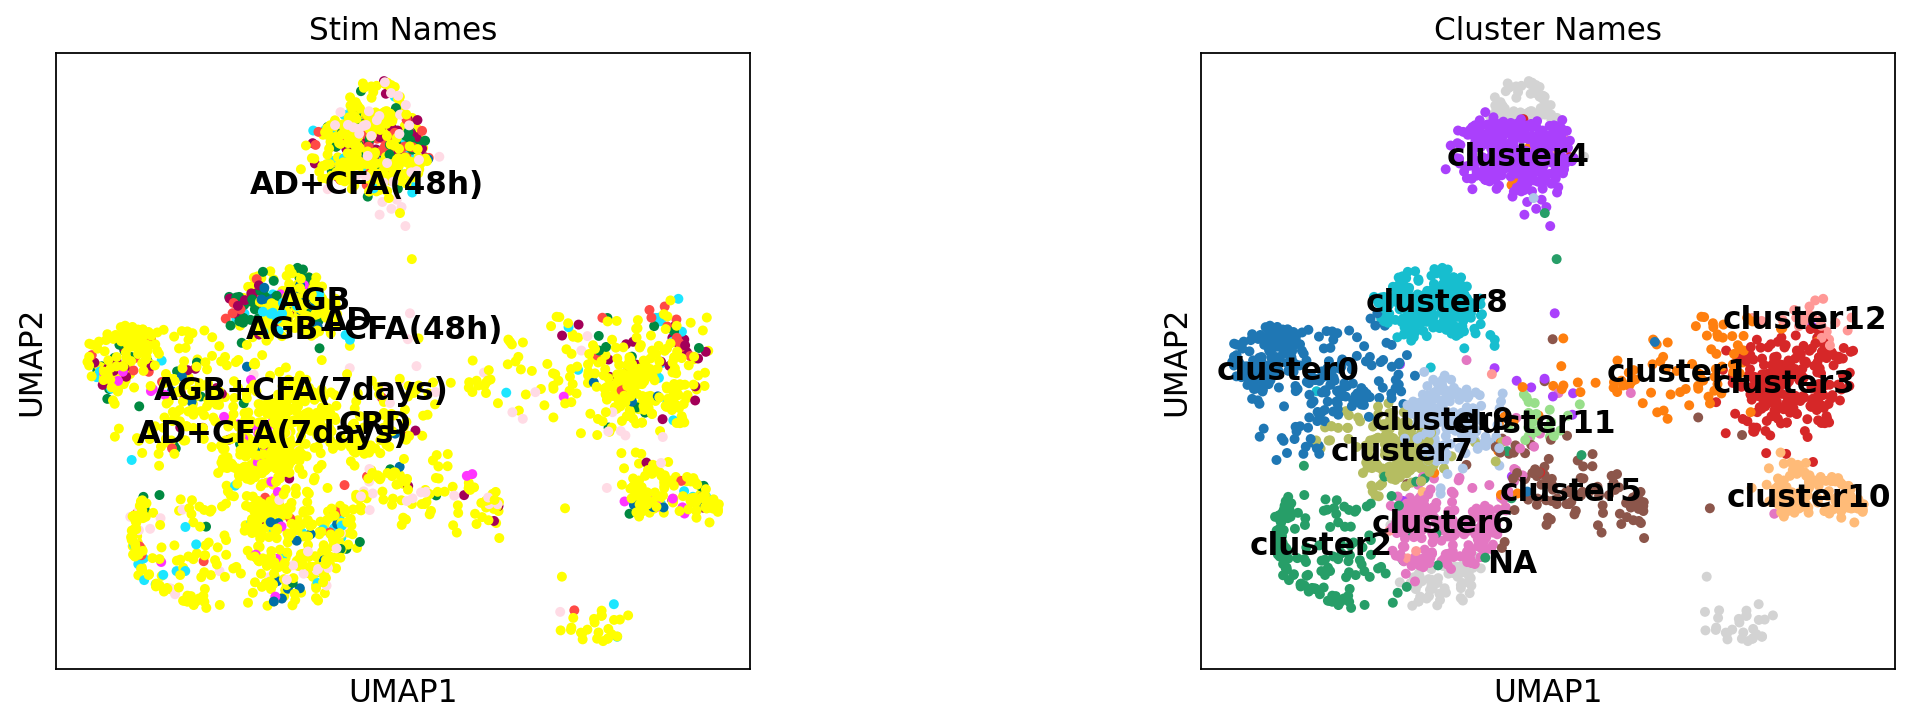

In [26]:
print(adata_campari.obs['stimulus_names'].value_counts())
sc.pl.umap(adata_campari, color=['stimulus_names','cluster_names'], legend_loc='on data', title=['Stim Names','Cluster Names'],
            wspace = 0.5,save = 'UMIs/integration_campari_clusters.png', size = 80,
              vmin=-2, vmax=2)#sc.pl.umap(adata_combined, color=['species', 'leiden', 'transferred_labels'], 
#           title='Combined UMAP with Original and Transferred Labels',
#           legend_loc='on data',save='umap_transfer_cluster_species_leiden_2.png')

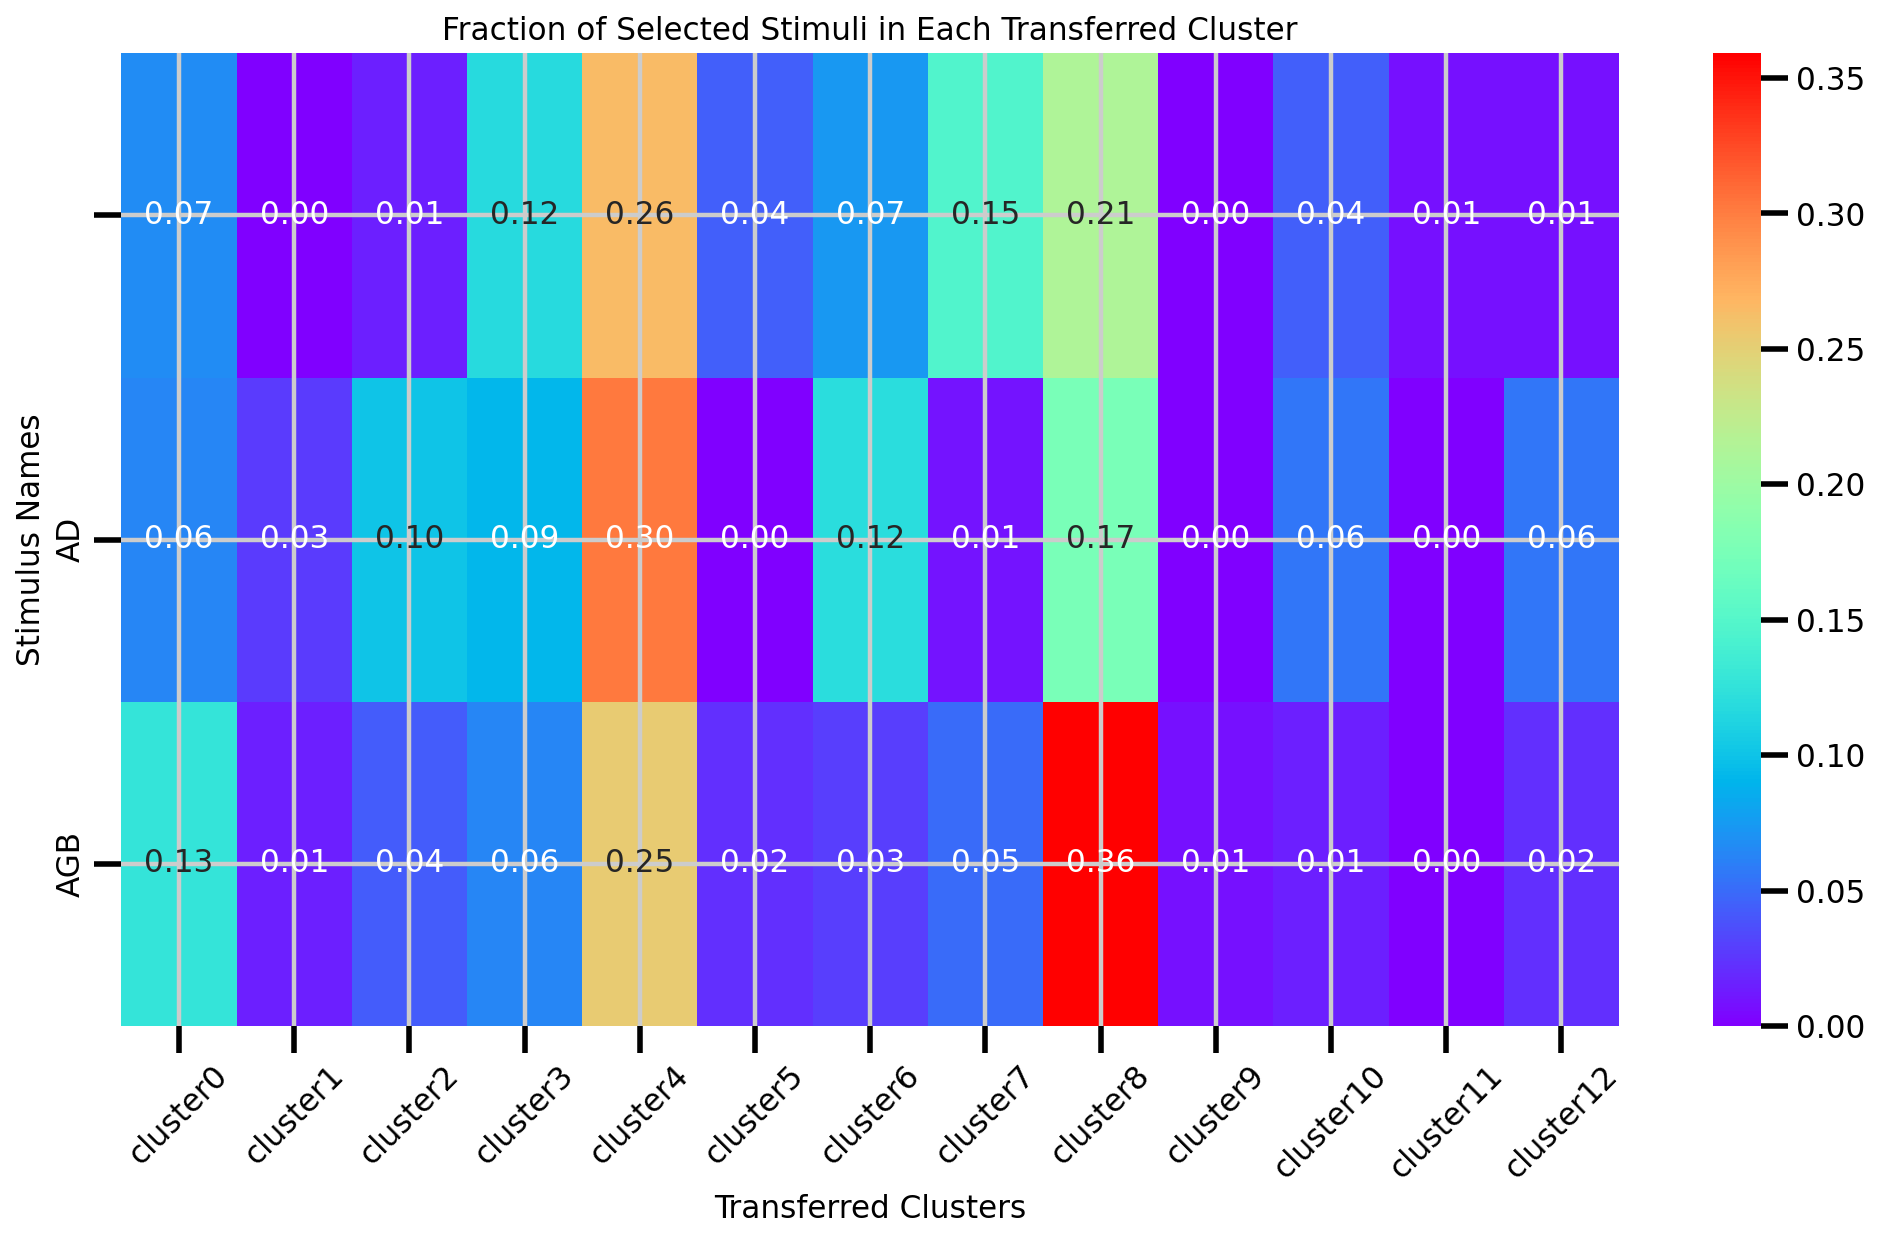

In [31]:
# Step 1: Define the stimuli you want to select by their IDs (e.g., 0, 1, 4, 5)
selected_stimuli = [0, 1, 4, 5]

# Step 2: Filter the adata object for the selected stimuli
filtered_df = adata_campari.obs[adata_campari.obs['stimulus'].isin(selected_stimuli)][['stimulus', 'stimulus_names', 'transfered_clusters', 'cluster_names']]

# Step 3: Count the occurrences of each combination of stimulus and transfered_clusters
counts = filtered_df.groupby(['stimulus_names', 'cluster_names']).size().reset_index(name='count')

# Step 4: Calculate the total count for each stimulus_names
total_per_stimulus = counts.groupby('stimulus_names')['count'].sum().reset_index(name='total_count')

# Step 5: Merge the total count with the counts DataFrame
counts = counts.merge(total_per_stimulus, on='stimulus_names')

# Step 6: Calculate the fraction of each stimulus_names that goes into each cluster_names
counts['fraction'] = counts['count'] / counts['total_count']

# Step 7: Create a pivot table to get stimulus_names on one axis and cluster_names on the other
pivot_table = counts.pivot(index='stimulus_names', columns='cluster_names', values='fraction')

# Step 8: Remove rows where all values are NaN (stimuli that were not selected)
pivot_table = pivot_table.dropna(how='all')

# Step 9: Plot the heatmap with no gridlines and linecolor set to match the background
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, cmap="rainbow", annot=True, fmt=".2f", linewidths=0, linecolor="white")  # Set linecolor to match the background
plt.title('Fraction of Selected Stimuli in Each Transferred Cluster')
plt.xlabel('Transferred Clusters')
plt.ylabel('Stimulus Names')

# Rotate x-axis labels for better readability if there are many cluster names
plt.xticks(rotation=45)
plt.show()


    stimulus_names cluster_names  count  total_count  fraction
0                       cluster0      0            0       NaN
1                       cluster1      0            0       NaN
2                       cluster2      0            0       NaN
3                       cluster3      0            0       NaN
4                       cluster4      0            0       NaN
..             ...           ...    ...          ...       ...
99             CRD      cluster8      0            0       NaN
100            CRD      cluster9      0            0       NaN
101            CRD     cluster10      0            0       NaN
102            CRD     cluster11      0            0       NaN
103            CRD     cluster12      0            0       NaN

[104 rows x 5 columns]


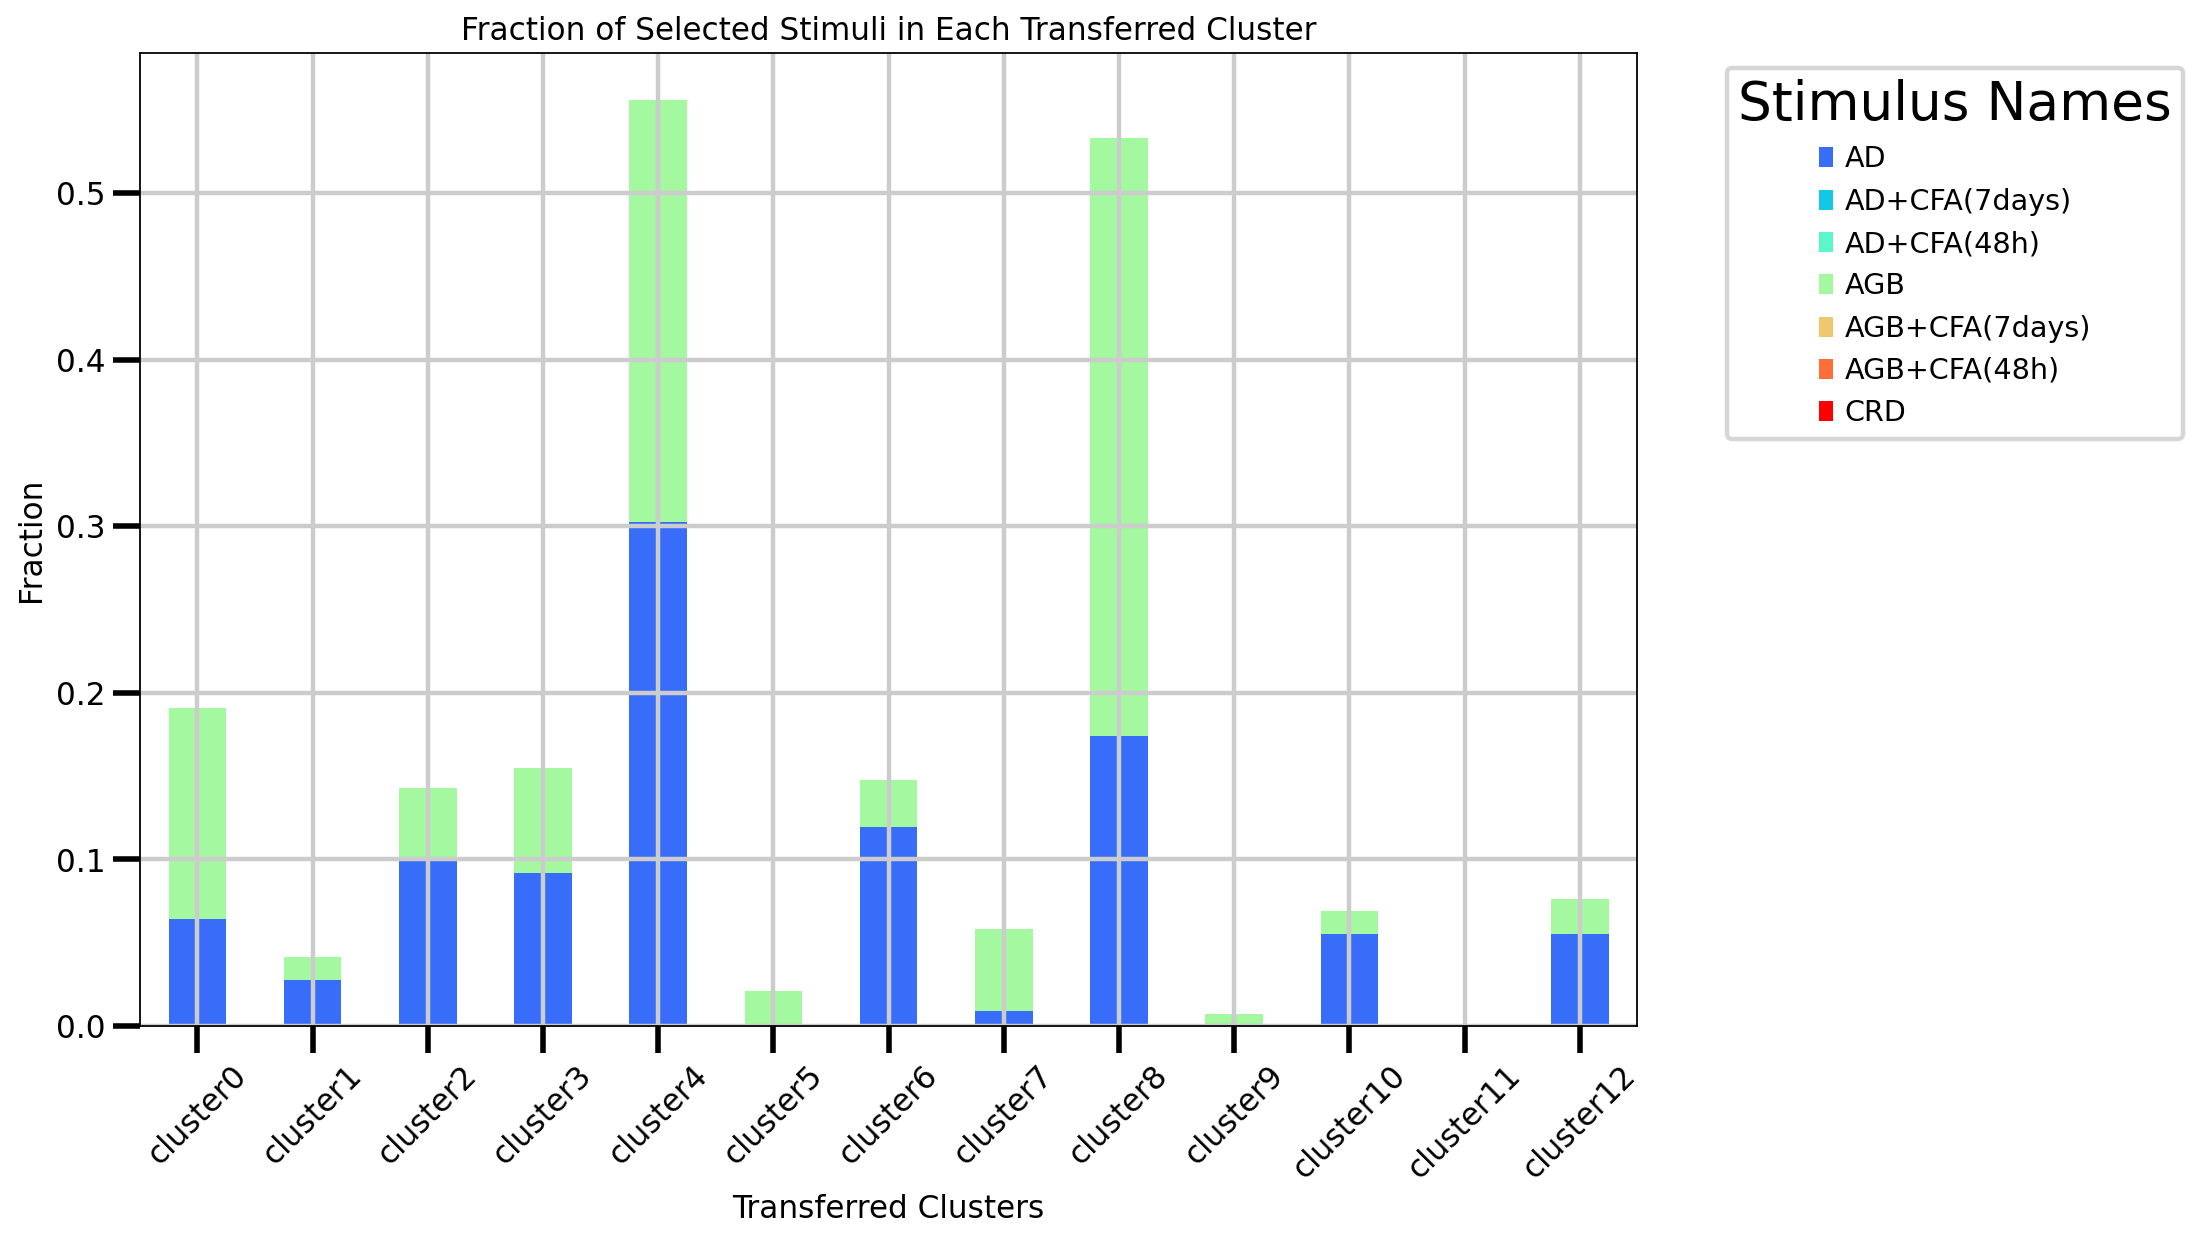

In [32]:
# Step 1: Define the stimuli you want to select by their IDs (e.g., 0, 1, 4, 5)
selected_stimuli = [0, 4, 5]

# Step 2: Filter the adata object for the selected stimuli and drop rows with NaN
filtered_df = adata_campari.obs[adata_campari.obs['stimulus'].isin(selected_stimuli)][['stimulus', 'stimulus_names', 'transfered_clusters', 'cluster_names']]
filtered_df = filtered_df.dropna(subset=['stimulus_names', 'cluster_names'])  # Drop NaNs

# Step 3: Count the occurrences of each combination of stimulus_names and cluster_names
counts = filtered_df.groupby(['stimulus_names', 'cluster_names']).size().reset_index(name='count')

# Step 4: Calculate the total count for each stimulus_names
total_per_stimulus = counts.groupby('stimulus_names')['count'].sum().reset_index(name='total_count')

# Step 5: Merge the total count with the counts DataFrame
counts = counts.merge(total_per_stimulus, on='stimulus_names')

# Step 6: Calculate the fraction of each stimulus_names that goes into each cluster_names
counts['fraction'] = counts['count'] / counts['total_count']

# Optional: Display the result
print(counts)

# Step 7: Create a bar plot with transfered_clusters on x-axis and stacked bars for stimuli
pivot_table = counts.pivot(index='stimulus_names', columns='cluster_names', values='fraction').fillna(0)

# Step 8: Plot a stacked bar plot using matplotlib
pivot_table.T.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='rainbow')

# Step 9: Customize the plot
plt.title('Fraction of Selected Stimuli in Each Transferred Cluster')
plt.xlabel('Transferred Clusters')
plt.ylabel('Fraction')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(title='Stimulus Names', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 10: Show the plot
plt.show()



In [29]:
#################################################################################
#################################################################################
#################################################################################
#################### HERE WE EXPORT ALL THE INFORMATION AS .MAT ################

### we export sparse data matrix, stimuli and flourecence information, umap transformation information and
### louvain transformation

### create and exportable varable list of genes names
gene_name = []
for i in range(len(adata_concat.var['gene_name'])):
    gene_name.append(adata_concat.var['gene_name'].iloc[i])
    
gene_name_all = []
for i in range(len(adata_all_concat.var['gene_name'])):
    gene_name_all.append(adata_all_concat.var['gene_name'].iloc[i])
### transform adata sparse matrix to scipy
x_all = adata_all_concat.X
x = adata_concat.X
### create exportable arrays with information about stimuli, fluorecence, and louvain transformations
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
cell_id = np.zeros((x.shape[0],))

louvain = np.zeros((x.shape[0],len(louvain_names)))
for i in range(x.shape[0]):
    stim[i] = adata_concat.obs['stimulus'][i]
    red[i] = adata_concat.obs['red'][i]
    green[i] = adata_concat.obs['green'][i]
    #cell_id[i] = adata.obs['cell_id'][i]

    count = 0
    for name in louvain_names:
        louvain[i,count] = adata_concat.obs[name][i]
        count = count + 1
data = {'umap': adata_concat.obsm['X_umap'],'gene_name' : np.array(gene_name_all),'gene_name_matrix' : np.array(gene_name),
        'sparse_matrix': x_all,'matrix': x,'stimuli':stim,
        'red_intesity': red, 'green_intensity': green, 'louvain' : louvain, 'louvain_name': louvain_names, 'cell_id': cell_id}

scipy.io.savemat(os.path.join(input_path , 'umap_control_embedding_date_'+str(today)+'.mat'), data) ### os.join path  + time so no manual!

#################################################################################
#################################################################################
#################################################################################